In [1]:
import datetime
import pickle

import pandas as pd
import geopandas as gpd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import segregation
from libpysal.weights.distance import DistanceBand
from esda.moran import Moran_Local, Moran

/home/h9b/GIT_REPOS/global-urban-building-completeness-analysis/venv/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_43963/2472761831.py:5: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://

In [2]:
def get_urban_centers_gdf_timeline(region, month):
    column_b = f'prediction_osm_completeness_{month.year}'    
    gdf = gpd.read_file(
        "../data/global_urban_building_completeness.gpkg",
        layer='rf_adjusted_prediction_reference_and_osm_urban_centers',
    )
    gdf.set_geometry(gdf["geometry"].centroid, inplace=True)

    gdf["osm_completeness"] = gdf[column_b]
    gdf.rename(columns={column_b: "prediction_osm_completeness"}, inplace=True)
    gdf.loc[gdf['sum_prediction_sqkm'] < 0, 'sum_prediction_sqkm'] = 0
    gdf.loc[gdf['osm_completeness'] < 0, 'osm_completeness'] = 0
    gdf.loc[gdf['osm_completeness'] > 1, 'osm_completeness'] = 1
    gdf = gdf.loc[gdf["region_wb"].isin(region)]
    gdf["sum_osm_building_area_sqkm"] = gdf["sum_prediction_sqkm"] * gdf["osm_completeness"]
    
    print(len(gdf))
    
    all_columns = gdf.columns
    include_fields=[
        "urban_center_id", "region_wb", "ghspop_2020", "sum_prediction_sqkm",
        "prediction_osm_completeness", "sum_osm_building_area_sqkm", "osm_completeness",
        "geometry"
    ]
    columns_to_drop = list(set(all_columns) - set(include_fields))    
    gdf.drop(
        columns_to_drop,
        axis=1,
        inplace=True
    )
    
    gdf.dropna(inplace=True)
    print(len(gdf))
    
    print(f"got {len(gdf)} samples")
    return gdf

## Configuration and Styles

In [4]:
model_name = "rf_adjusted"
training_data = "reference_and_osm"

wb_regions = [
    ["East Asia & Pacific"],
    ["Europe & Central Asia"],
    ["Latin America & Caribbean"],
    ["Middle East & North Africa"],
    ["North America"],
    ["South Asia"],
    ["Sub-Saharan Africa"],
    [
        "Europe & Central Asia", 
        "Latin America & Caribbean", 
        "North America", 
        "East Asia & Pacific", 
        "South Asia", 
        "Middle East & North Africa",
        "Sub-Saharan Africa"
    ],
]

linestyles = [
    ('dotted',                (0, (1, 1))),
    ('densely dashed',        (0, (5, 1))),
    ('densely dashed',        (0, (5, 1))),
    ('solid',                 (0, ())),
    ('dotted',                (0, (1, 1))),
    ('solid',                 (0, ())),
    ('densely dashed',        (0, (5, 1))),
    ('solid',                 (0, ())),
]

label_strings = [
    "East Asia & Pacific",
    "Europe & Central Asia",
    "Latin America & Caribbean",
    "Middle East & North Africa",
    "North America",
    "South Asia",
    "Sub-Saharan Africa",
    "all"
]

cmap = matplotlib.cm.get_cmap('tab10')
colors_dict = {
    "East Asia & Pacific": cmap(0),
    "Europe & Central Asia": cmap(0.125),
    "Latin America & Caribbean": cmap(0.25),
    "Middle East & North Africa": cmap(0.375),
    "North America": cmap(0.5),
    "South Asia": cmap(0.625),
    "Sub-Saharan Africa": cmap(0.75),
    "all": "black",
}


all_months = [
    datetime.date(2008, 1, 1),
    datetime.date(2009, 1, 1),
    datetime.date(2010, 1, 1),
    datetime.date(2011, 1, 1),
    datetime.date(2012, 1, 1),
    datetime.date(2013, 1, 1),
    datetime.date(2014, 1, 1),
    datetime.date(2015, 1, 1),
    datetime.date(2016, 1, 1),
    datetime.date(2017, 1, 1),
    datetime.date(2018, 1, 1),
    datetime.date(2019, 1, 1),
    datetime.date(2020, 1, 1),
    datetime.date(2021, 1, 1),
    datetime.date(2022, 1, 1),
    datetime.date(2023, 1, 1),
]

outfile = "../data/inequality_stats_data.pkl"

## Calculate Moran's I and Gini Coefficient
this takes around 35 minutes.

In [4]:
morans_lists = {}
gini_lists = {}
pop_low_completeness_lists = {}
pop_high_completeness_lists = {}
avg_completeness_lists = {}

for i, region in enumerate(wb_regions):
    
    morans_lists[i] = []
    gini_lists[i] = []
    pop_low_completeness_lists[i] = []
    pop_high_completeness_lists[i] = []
    avg_completeness_lists[i] = []
    
    for j, month in enumerate(all_months):
        print(month)
        
        df = get_urban_centers_gdf_timeline(
            region,
            month,
        ).reset_index()
        
        avg_completeness_lists[i].append(
            df["prediction_osm_completeness"].mean()
        )
        
        index = segregation.singlegroup.gini.Gini(
            df[['sum_osm_building_area_sqkm', 'sum_prediction_sqkm']],
            'sum_osm_building_area_sqkm',
            'sum_prediction_sqkm'
        )
        gini_lists[i].append(index.statistic)

        w = DistanceBand.from_dataframe(df, 5, binary=False)
        w.transform = 'r'

        df = df.loc[~df.index.isin(w.islands)]

        w = DistanceBand.from_dataframe(df, 5, binary=False)
        w.transform = 'r'

        y = df['osm_completeness']
        # global and local Moran's I
        try:
            moran_global = Moran(y, w)
            moran_loc = Moran_Local(y, w)
            df[f"{month.year}_moran_loc"] = moran_loc.Is
            df[f"{month.year}_moran_loc_q"] = moran_loc.q
            df[f"{month.year}_moran_loc_p_sim"] = moran_loc.p_sim
            df[f"{month.year}_moran_global"] = moran_global.I
        except (ZeroDivisionError, StopIteration):
            df[f"{month.year}_moran_loc"] = np.nan
            df[f"{month.year}_moran_global"] = np.nan

        morans_lists[i].append(moran_global.I)

        pop_low_completeness = df.loc[df['osm_completeness'] < 0.2]["ghspop_2020"].sum() / df["ghspop_2020"].sum()
        pop_low_completeness_lists[i].append(pop_low_completeness)

        pop_high_completeness = df.loc[df['osm_completeness'] >= 0.8]["ghspop_2020"].sum() / df["ghspop_2020"].sum()
        pop_high_completeness_lists[i].append(pop_high_completeness)

2008-01-01
3068
3064
got 3064 samples
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 831, ' is an island (no neighbors)')
('WARNING: ', 891, ' is an island (no neighbors)')
('WARNING: ', 3060, ' is an island (no neighbors)')
('WARNING: ', 3061, ' is an island (no neighbors)')
('WARNING: ', 3062, ' is an island (no neighbors)')
2009-01-01
3068
3064
got 3064 samples
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 831, ' is an island (no neighbors)')
('WARNING: ', 891, ' is an island (no neighbors)')
('WARNING: ', 3060, ' is an island (no neighbors)')
('WARNING: ', 3061, ' is an island (no neighbors)')
('WARNING: ', 3062, ' is an island (no neighbors)')
2010-01-01
3068
3064
got 3064 samples
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 831, ' is an island (no neighbors)')
('WARNING: ', 891, ' is an island (no neighbors)')
('WARNING: ', 3060, ' is an island (no neighbors)')
('WARNING: ', 3061, ' is an island (no neighbors)')
('WARNING: ', 306

2012-01-01
1351
1351
got 1351 samples
('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 1099, ' is an island (no neighbors)')
('WARNING: ', 1103, ' is an island (no neighbors)')
('WARNING: ', 1246, ' is an island (no neighbors)')
('WARNING: ', 1281, ' is an island (no neighbors)')
('WARNING: ', 1283, ' is an island (no neighbors)')
('WARNING: ', 1286, ' is an island (no neighbors)')
('WARNING: ', 1290, ' is an island (no neighbors)')
('WARNING: ', 1341, ' is an island (no neighbors)')
('WARNING: ', 1342, ' is an island (no neighbors)')
('WARNING: ', 1343, ' is an island (no neighbors)')
('WARNING: ', 1349, ' is an island (no neighbors)')
('WARNING: ', 1350, ' is an island (no neighbors)')
2013-01-01
1351
1351
got 1351 samples
('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 1099, ' is an island (no neighbors)')
('WARNING: ', 1103, ' is an island (no neighbors)')
('WARNING: ', 1246, ' is an island (no neighbors)')
('WARNING: ', 1281, ' is an island (no neighbo

2008-01-01
1073
1073
got 1073 samples
2009-01-01
1073
1073
got 1073 samples
2010-01-01
1073
1073
got 1073 samples
2011-01-01
1073
1073
got 1073 samples
2012-01-01
1073
1073
got 1073 samples
2013-01-01
1073
1073
got 1073 samples
2014-01-01
1073
1073
got 1073 samples
2015-01-01
1073
1073
got 1073 samples
2016-01-01
1073
1073
got 1073 samples
2017-01-01
1073
1073
got 1073 samples
2018-01-01
1073
1073
got 1073 samples
2019-01-01
1073
1073
got 1073 samples
2020-01-01
1073
1073
got 1073 samples
2021-01-01
1073
1073
got 1073 samples
2022-01-01
1073
1073
got 1073 samples
2023-01-01
1073
1073
got 1073 samples
2008-01-01
901
884
got 884 samples
('WARNING: ', 720, ' is an island (no neighbors)')
2009-01-01
901
884
got 884 samples
('WARNING: ', 720, ' is an island (no neighbors)')
2010-01-01
901
884
got 884 samples
('WARNING: ', 720, ' is an island (no neighbors)')
2011-01-01
901
884
got 884 samples
('WARNING: ', 720, ' is an island (no neighbors)')
2012-01-01
901
884
got 884 samples
('WARNING: ',

('WARNING: ', 11575, ' is an island (no neighbors)')
('WARNING: ', 13078, ' is an island (no neighbors)')
('WARNING: ', 13124, ' is an island (no neighbors)')
('WARNING: ', 13125, ' is an island (no neighbors)')
('WARNING: ', 13126, ' is an island (no neighbors)')
2009-01-01
13189
13128
got 13128 samples
('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 89, ' is an island (no neighbors)')
('WARNING: ', 889, ' is an island (no neighbors)')
('WARNING: ', 966, ' is an island (no neighbors)')
('WARNING: ', 5162, ' is an island (no neighbors)')
('WARNING: ', 5683, ' is an island (no neighbors)')
('WARNING: ', 7072, ' is an island (no neighbors)')
('WARNING: ', 7132, ' is an island (no neighbors)')
('WARNING: ', 7246, ' is an island (no neighbors)')
('WARNING: ', 8229, ' is an island (no neighbors)')
('WARNING: ', 8894, ' is an island (no neighbors)')
('WARNING: ', 8950, ' is an island (no neighbors)')
('WARNING: ', 9003, ' is an island (no neighbors)')
('WARNING: ', 11575, ' is

('WARNING: ', 7072, ' is an island (no neighbors)')
('WARNING: ', 7132, ' is an island (no neighbors)')
('WARNING: ', 7246, ' is an island (no neighbors)')
('WARNING: ', 8229, ' is an island (no neighbors)')
('WARNING: ', 8894, ' is an island (no neighbors)')
('WARNING: ', 8950, ' is an island (no neighbors)')
('WARNING: ', 9003, ' is an island (no neighbors)')
('WARNING: ', 11575, ' is an island (no neighbors)')
('WARNING: ', 13078, ' is an island (no neighbors)')
('WARNING: ', 13124, ' is an island (no neighbors)')
('WARNING: ', 13125, ' is an island (no neighbors)')
('WARNING: ', 13126, ' is an island (no neighbors)')
2018-01-01
13189
13128
got 13128 samples
('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 89, ' is an island (no neighbors)')
('WARNING: ', 889, ' is an island (no neighbors)')
('WARNING: ', 966, ' is an island (no neighbors)')
('WARNING: ', 5162, ' is an island (no neighbors)')
('WARNING: ', 5683, ' is an island (no neighbors)')
('WARNING: ', 7072, ' is 

## Save Results

In [5]:
stats = []
for i, region in enumerate(wb_regions):
    stats.append([
        label_strings[i],
        all_months,
        avg_completeness_lists[i],
        pop_low_completeness_lists[i],
        pop_high_completeness_lists[i],
        morans_lists[i],
        gini_lists[i]
    ])
    
with open(outfile, 'wb') as f:
    pickle.dump(stats, f)

## Create Plots

In [8]:
with open(outfile, 'rb') as f:
    stats_new = pickle.load(f)

columns = [
    "region",
    "months",
    "avg_completeness",
    "pop_low_completeness",
    "pop_high_completeness",
    "morans",
    "gini"
]    
    
stats_df = pd.DataFrame(
    stats_new,
    columns=columns
)
display(stats_df)

display(
    stats_df.loc[stats_df["region"] == 'all']["morans"].values
)

,region,months,avg_completeness,pop_low_completeness,pop_high_completeness,morans,gini
0,East Asia & Pacific,"[2008-01-01, 2009-01-01, 2010-01-01, 2011-01-0...","[1.4690614092564798e-05, 0.0002196568324450948...","[1.0, 0.9996667066569578, 0.999627877363249, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 5.0668998344426636e-...","[0.1716418789738026, 0.013551918235442516, 0.0...","[0.965895806028336, 0.9216926333522248, 0.8994..."
1,Europe & Central Asia,"[2008-01-01, 2009-01-01, 2010-01-01, 2011-01-0...","[0.0011627596614956178, 0.016043069942020503, ...","[1.0, 0.9682684187001325, 0.8485578080795433, ...","[0.0, 0.0035593448638075063, 0.005806198138063...","[0.08782706354595551, 0.09525536339130095, 0.2...","[0.8939698271386285, 0.8248356687748615, 0.781..."
2,Latin America & Caribbean,"[2008-01-01, 2009-01-01, 2010-01-01, 2011-01-0...","[3.1717684542811328e-06, 0.0001188603380468235...","[1.0, 1.0, 1.0, 0.9965178530166998, 0.99571889...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.000431626815775913...","[-0.0007276462104990921, -0.004066671408525841...","[0.9669383297650196, 0.8830957176516105, 0.780..."
3,Middle East & North Africa,"[2008-01-01, 2009-01-01, 2010-01-01, 2011-01-0...","[8.553183292374636e-06, 0.00019352124130558865...","[1.0, 1.0, 1.0, 0.9997232020418172, 0.99528092...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00091928...","[-0.0008869547437845053, 0.042818700304036755,...","[0.9549667875621127, 0.9082967816407176, 0.836..."
4,North America,"[2008-01-01, 2009-01-01, 2010-01-01, 2011-01-0...","[0.000337224865925355, 0.004168444450155686, 0...","[1.0, 1.0, 0.9308887319609644, 0.9058913160570...","[0.0, 0.0, 0.0, 0.0023837327148642953, 0.00238...","[0.09195098165366244, 0.06556799184301645, 0.0...","[0.9554878935284568, 0.73294523351026, 0.73339..."
5,South Asia,"[2008-01-01, 2009-01-01, 2010-01-01, 2011-01-0...","[1.4085868418162705e-07, 1.8345512429627432e-0...","[1.0, 1.0, 1.0, 1.0, 0.9988201055736695, 0.998...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1448043011831...","[-0.00018751240519812001, 0.006886379053044532...","[0.9994069858178637, 0.9185524799361644, 0.867..."
6,Sub-Saharan Africa,"[2008-01-01, 2009-01-01, 2010-01-01, 2011-01-0...","[4.716258881908632e-06, 2.6161993438457232e-05...","[1.0, 1.0, 1.0, 1.0, 0.9982636805469115, 0.976...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.000674882384966894...","[-0.0005604510342915023, 0.001772761894974186,...","[0.9828888960889223, 0.9112988163873947, 0.889..."
7,all,"[2008-01-01, 2009-01-01, 2010-01-01, 2011-01-0...","[0.00013453626944874707, 0.0018553645718137578...","[1.0, 0.9961047450311656, 0.9775927949437847, ...","[0.0, 0.0004247422984585347, 0.000692862882589...","[0.11415290733983405, 0.13354472926605873, 0.3...","[0.9716066431843842, 0.9339375720055073, 0.915..."


array([list([0.11415290733983405, 0.13354472926605873, 0.31480632812684956, 0.5361708282698516, 0.6546690545969901, 0.6964304221494838, 0.7064441024637241, 0.6881886208311259, 0.6671217841358041, 0.6305922169921604, 0.5954113540336164, 0.5660900163183514, 0.5719466584385545, 0.565683633181122, 0.5688909015673617, 0.5593474383773549])],
      dtype=object)

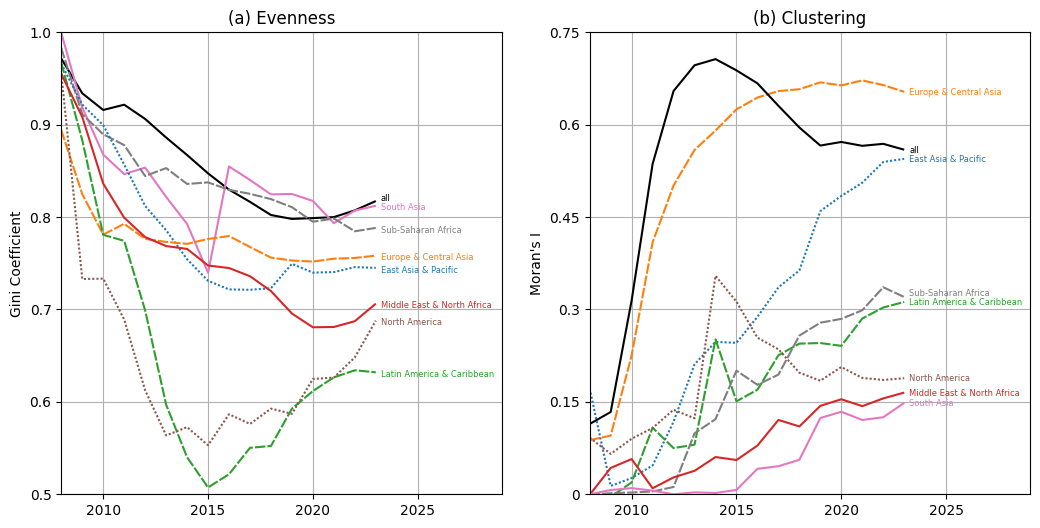

In [7]:
fontsize = 6

fig, axs = plt.subplots(1, 2, figsize=(12.5, 6))
gs1 = gridspec.GridSpec(1, 2)
gs1.update(wspace=0.2, hspace=0.2) # set the spacing between axes.

max_y_values = {
    "gini": [],
    "morans": []
}

columns = [
    "gini",
    "morans"
]


cmap = matplotlib.cm.get_cmap('tab10')
colors_dict = {
    "East Asia & Pacific": cmap(0),
    "Europe & Central Asia": cmap(0.125),
    "Latin America & Caribbean": cmap(0.25),
    "Middle East & North Africa": cmap(0.375),
    "North America": cmap(0.5),
    "South Asia": cmap(0.625),
    "Sub-Saharan Africa": cmap(0.75),
    "all": "black",
}

linestyles_dict = {
    "East Asia & Pacific": ('dotted', (0, (1, 1))),
    "Europe & Central Asia": ('densely dashed', (0, (5, 1))),
    "Latin America & Caribbean": ('densely dashed', (0, (5, 1))),
    "Middle East & North Africa": ('solid', (0, ())),
    "North America": ('dotted', (0, (1, 1))),
    "South Asia": ('solid',(0, ())),
    "Sub-Saharan Africa": ('densely dashed', (0, (5, 1))),
    "all":  ('solid', (0, ())),
}
    

label_strings_new = {
    "gini": [
        "all",
        "South Asia",
        "Sub-Saharan Africa",
        "East Asia & Pacific",
        "Europe & Central Asia",
        "Latin America & Caribbean",
        "Middle East & North Africa",
        "North America",
    ],
    "morans": [
        "Europe & Central Asia",
        "all",
        "East Asia & Pacific",
        "Latin America & Caribbean",
        "Sub-Saharan Africa",
        "North America",
        "Middle East & North Africa",
        "South Asia",
    ]
}

for j, column in enumerate(columns):
    ax = plt.subplot(gs1[j])
    
    for i, region in enumerate(label_strings_new[column]):
        region_df = stats_df.loc[stats_df["region"] == region]

        max_y_values[column].append(
            region_df[column].to_list()[0][-1]
        )

        ax.plot(
            region_df["months"].to_list()[0],
            region_df[column].to_list()[0],
            label=region,
            color=colors_dict[region],
            linestyle=linestyles_dict[region][1]
        )

        if region == 'all' and column == 'gini':
            label_position = max_y_values[column][i] + 0.005
        elif region == 'Sub-Saharan Africa' and column == 'morans':
            label_position = max_y_values[column][i] + 0.0075
        else:
            label_position = max_y_values[column][i]

        ax.annotate(
            region,
            (datetime.date(2023, 4, 1), label_position - 0.005),
            fontsize=fontsize,
            color=colors_dict[region]
        )
    
ax = plt.subplot(gs1[0])
ax1 = plt.subplot(gs1[1])  

ax.set_title("(a) Evenness")
ax.set_ylabel("Gini Coefficient")
ax.set_xlim([datetime.date(2008, 1, 1), datetime.date(2029, 1, 1)])
ax.set_ylim([0.5,1.0])
ax.set_xticks([
    datetime.date(2010, 1, 1),
    datetime.date(2015, 1, 1),
    datetime.date(2020, 1, 1),
    datetime.date(2025, 1, 1),
])
ax.set_xticklabels(["2010", "2015", "2020", "2025"])
ax.grid()

ax1.set_title("(b) Clustering")
ax1.set_ylabel("Moran's I")
ax1.set_xlim([datetime.date(2008, 1, 1), datetime.date(2029, 1, 1)])
ax1.grid()
ax1.set_xticks([
    datetime.date(2010, 1, 1),
    datetime.date(2015, 1, 1),
    datetime.date(2020, 1, 1),
    datetime.date(2025, 1, 1),
])
ax1.set_xticklabels(["2010", "2015", "2020", "2025"])
ax1.set_yticks([
    0, 0.15, 0.30, 0.45, 0.6, 0.75
])
ax1.set_yticklabels([0, 0.15, 0.30, 0.45, 0.6, 0.75])
ax1.set_ylim([0,0.75])


plt.savefig(
    f"../figures/completeness_inequality_per_month_by_region_{model_name}.png",
    dpi=300,
    bbox_inches = 'tight',
    pad_inches = 0.25
)

plt.show()  

## Get Data for Europe & Central Asia and Sub-Saharan Africa

In [23]:
display(df)

,index,urban_center_id,region_wb,ghspop_2020,sum_prediction_sqkm,prediction_osm_completeness,geometry,osm_completeness,sum_osm_building_area_sqkm,2023_moran_loc,2023_moran_loc_q,2023_moran_loc_p_sim,2023_moran_global
0,0,3369,Middle East & North Africa,50136.0,2.998257,0.075214,POINT (20.22275 30.75541),0.075214,0.225510,-0.269353,2,0.100,0.559347
1,1,10716,East Asia & Pacific,115875.0,6.094266,0.003428,POINT (103.38445 23.36780),0.003428,0.020891,0.359913,3,0.001,0.559347
3,3,4417,Middle East & North Africa,70800.0,2.380862,0.016485,POINT (36.20832 34.00304),0.016485,0.039248,-0.025768,2,0.348,0.559347
4,4,9657,South Asia,692966.0,6.018669,0.068717,POINT (87.30793 22.32927),0.068717,0.413584,0.213088,3,0.001,0.559347
5,5,12270,East Asia & Pacific,1865648.0,43.569861,0.222320,POINT (113.50650 22.29528),0.222320,9.686439,0.014125,3,0.001,0.559347
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13120,13181,13160,East Asia & Pacific,1053.0,0.008303,0.000000,POINT (144.44432 -5.75810),0.000000,0.000000,0.016911,3,0.404,0.559347
13121,13182,13161,East Asia & Pacific,10633.0,0.065188,0.204491,POINT (144.45070 -5.79862),0.204491,0.013330,0.018710,3,0.326,0.559347
13122,13183,13162,East Asia & Pacific,4.0,0.002113,0.000000,POINT (144.36950 -5.04517),0.000000,0.000000,-0.086428,2,0.223,0.559347
13123,13184,13186,East Asia & Pacific,4288.0,0.088922,0.380562,POINT (155.69301 -6.74976),0.380562,0.033840,0.944503,1,0.001,0.559347


In [24]:
wb_regions = [
    ["East Asia & Pacific"],
    ["Europe & Central Asia"],
    ["Latin America & Caribbean"],
    ["Middle East & North Africa"],
    ["North America"],
    ["South Asia"],
    ["Sub-Saharan Africa"],
    [
        "Europe & Central Asia", 
        "Latin America & Caribbean", 
        "North America", 
        "East Asia & Pacific", 
        "South Asia", 
        "Middle East & North Africa",
        "Sub-Saharan Africa"
    ],
]


all_months = [
    datetime.date(2010, 1, 1),
    datetime.date(2014, 1, 1),
    datetime.date(2023, 1, 1),
]

colors = [
    "blue",
    "green",
    "yellow",
    "violet"
]

column = "osm_completeness"

for j, region_id in enumerate([1, 6]):
    region = wb_regions[region_id]
    
    for i, month in enumerate(all_months):
        
        # need to make sure to reset index!
        df = get_urban_centers_gdf_timeline(
            region,
            month
        )
        df.drop(["prediction_osm_completeness"], axis=1, inplace=True)
        
        index = segregation.singlegroup.gini.Gini(
            df[['sum_osm_building_area_sqkm', 'sum_prediction_sqkm']],
            'sum_osm_building_area_sqkm',
            'sum_prediction_sqkm'
        )
        gini = index.statistic
        
        df.reset_index(inplace=True)
        
        w = DistanceBand.from_dataframe(df, 5, binary=False)
        w.transform = 'r'

        df = df.loc[~df.index.isin(w.islands)]
        w = DistanceBand.from_dataframe(df, 5, binary=False)
        w.transform = 'r'

        y = df[column]
        # global and local Moran's I
        try:
            moran_global = Moran(y, w)
            moran_loc = Moran_Local(y, w)
            df[f"{column}_moran_loc"] = moran_loc.Is
            df[f"{column}_moran_loc_q"] = moran_loc.q
            df[f"{column}_moran_loc_p_sim"] = moran_loc.p_sim
            df[f"{column}_moran_global"] = moran_global.I
        except (ZeroDivisionError, StopIteration):
            df[f"{column}_moran_loc"] = np.nan
            df[f"{column}_moran_global"] = np.nan

        morans = moran_global.I

        print(region, month, gini, morans)

        df["alpha"] = 0.2
        df.loc[df["osm_completeness_moran_loc_p_sim"] < 0.1, "alpha"] = 1
        df.to_file(
            "../data/global_urban_building_completeness.gpkg",
            layer=f'{region[0]}_{month}',
            driver="GPKG"
        )

1351
1351
got 1351 samples
('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 1099, ' is an island (no neighbors)')
('WARNING: ', 1103, ' is an island (no neighbors)')
('WARNING: ', 1246, ' is an island (no neighbors)')
('WARNING: ', 1281, ' is an island (no neighbors)')
('WARNING: ', 1283, ' is an island (no neighbors)')
('WARNING: ', 1286, ' is an island (no neighbors)')
('WARNING: ', 1290, ' is an island (no neighbors)')
('WARNING: ', 1341, ' is an island (no neighbors)')
('WARNING: ', 1342, ' is an island (no neighbors)')
('WARNING: ', 1343, ' is an island (no neighbors)')
('WARNING: ', 1349, ' is an island (no neighbors)')
('WARNING: ', 1350, ' is an island (no neighbors)')
['Europe & Central Asia'] 2010-01-01 0.7810666195221699 0.22567278130379045
1351
1351
got 1351 samples
('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 1099, ' is an island (no neighbors)')
('WARNING: ', 1103, ' is an island (no neighbors)')
('WARNING: ', 1246, ' is an island (no neigh